In [102]:
import pickle
from itertools import chain

import numpy as np
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Bidirectional, Embedding, Dropout, SpatialDropout1D, Dense, LSTM, \
    BatchNormalization
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.ops.init_ops import Constant
from tqdm import tqdm,trange
import matplotlib.pyplot as plt

In [89]:
epochs = 100
BS = 512
glove_dimension=100

In [90]:
# Load the data for three splits
train_dict = pickle.load(open("./data/train.pkl", 'rb'))
val_dict = pickle.load(open("./data/val.pkl", 'rb'))
test_dict = pickle.load(open("./data/test.pkl", 'rb'))

glove_dict = {}
with open('./glove.6B.100d.txt', 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_dict[word] = vector

400000it [00:10, 37065.23it/s]


In [91]:
encoded_dict = {}
count=0
total=0
glove_keys = glove_dict.keys()
for i in [train_dict, val_dict, test_dict]:
    for j in trange(len(i['word_seq'])):
        for word in i['word_seq'][j]:
            if word not in glove_keys:
                encoded_dict[word] = np.random.rand(1, glove_dimension)[0]
                count+=1
                total+=1
            else:
                encoded_dict[word] = glove_dict[word]
                total+=1
print("words not found {}".format(count))
print("words total {}".format(total))
print(len(encoded_dict))
np.save("./glove/encoded_dict.npy", encoded_dict)

100%|██████████| 2950/2950 [00:00<00:00, 7843.76it/s]


words not found 906974
words total 3776000
92288


In [92]:
encoded_word2id = {}
encoded_matrix = np.zeros((len(encoded_dict.keys()), 100), dtype=float)
for i, word in enumerate(encoded_dict.keys()):
    encoded_word2id[word] = i
    encoded_matrix[i] = encoded_dict[word]
print(encoded_matrix.shape)
np.save("./glove/encoded_matrix.npy", encoded_matrix)

(92288, 100)


In [93]:
# Build the tag <--> index dictionary and add PAD tag into it
tag_list = list(set(chain(*train_dict["tag_seq"])))
tag_to_index_dict = {t: i for i, t in enumerate(tag_list)}
index_to_tag_dict = {i: t for i, t in enumerate(tag_list)}

train_tag = [[tag_to_index_dict[tag] for tag in train_dict['tag_seq'][i]] for i in range(len(train_dict['tag_seq']))]
val_tag = [[tag_to_index_dict[tag] for tag in val_dict['tag_seq'][i]] for i in range(len(val_dict['tag_seq']))]

# save out dictionary for generation
np.save("./lstm_model/model_tag2id_e{}_bs{}.npy".format(epochs, BS), tag_to_index_dict)
np.save("./lstm_model/model_id2tag_e{}_bs{}.npy".format(epochs, BS), index_to_tag_dict)

In [94]:
embedding_dim=glove_dimension
num_words=len(encoded_dict)
input_length = 128
n_tags = len(tag_to_index_dict)
print(embedding_dim,num_words, input_length, n_tags)

100 92288 128 65


In [95]:
# Set our model
def get_bi_lstm_model():
    model = Sequential()
    model.add(Embedding(num_words,
                        embedding_dim,
                        embeddings_initializer=Constant(encoded_matrix),
                        input_length=input_length,
                        trainable=True))
    model.add(SpatialDropout1D(0.2))
    model.add(BatchNormalization())
    adam = Adam(lr=0.0015, beta_1=0.9, beta_2=0.999)
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Dense(units=n_tags, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

In [96]:
def train_model(X, y, val_X, val_y, model):
    hist = model.fit(X, y, batch_size=512, verbose=1, epochs=epochs, validation_data=(val_X, val_y), shuffle=True)
    return hist


model_bilstm_lstm = get_bi_lstm_model()
plot_model(model_bilstm_lstm,show_shapes=True)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 128, 100)          9228800   
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 128, 100)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 100)          400       
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128, 128)          84480     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
dense_13 (Dense)             (None, 128, 65)           8385      
Total params: 9,322,065
Trainable params: 9,321,865
Non-trainable params: 200
_________________________________________

In [97]:
train_input = np.array(
    [[encoded_word2id[word] for word in train_dict['word_seq'][i]] for i in range(len(train_dict['word_seq']))])
val_input = np.array(
    [[encoded_word2id[word] for word in val_dict['word_seq'][i]] for i in range(len(val_dict['word_seq']))])
test_input = np.array(
    [[encoded_word2id[word] for word in test_dict['word_seq'][i]] for i in range(len(test_dict['word_seq']))])
train_output = np.array(
    [[tag_to_index_dict[tag] for tag in train_dict['tag_seq'][i]] for i in range(len(train_dict['tag_seq']))])
val_output = np.array(
    [[tag_to_index_dict[tag] for tag in val_dict['tag_seq'][i]] for i in range(len(val_dict['tag_seq']))])

In [98]:
print(train_input.shape,val_input.shape,test_input.shape)
print(train_output.shape,val_output.shape)

(23600, 128) (2950, 128) (2950, 128)
(23600, 128) (2950, 128)


In [99]:
history = train_model(train_input, train_output, val_input, val_output, model_bilstm_lstm)

Epoch 1/100
47/47 [==============================] - 32s 687ms/step - loss: 1.6808 - accuracy: 0.6923 - val_loss: 1.0068 - val_accuracy: 0.7742
Epoch 2/100
47/47 [==============================] - 31s 666ms/step - loss: 0.9026 - accuracy: 0.7813 - val_loss: 0.8605 - val_accuracy: 0.7778
Epoch 3/100
47/47 [==============================] - 31s 656ms/step - loss: 0.7772 - accuracy: 0.8008 - val_loss: 0.7357 - val_accuracy: 0.8005
Epoch 4/100
47/47 [==============================] - 31s 656ms/step - loss: 0.6813 - accuracy: 0.8214 - val_loss: 0.6348 - val_accuracy: 0.8263
Epoch 5/100
47/47 [==============================] - 31s 665ms/step - loss: 0.6125 - accuracy: 0.8375 - val_loss: 0.5620 - val_accuracy: 0.8469
Epoch 6/100
47/47 [==============================] - 31s 659ms/step - loss: 0.5630 - accuracy: 0.8492 - val_loss: 0.5166 - val_accuracy: 0.8597
Epoch 7/100
47/47 [==============================] - 31s 654ms/step - loss: 0.5247 - accuracy: 0.8582 - val_loss: 0.4838 - val_accuracy:

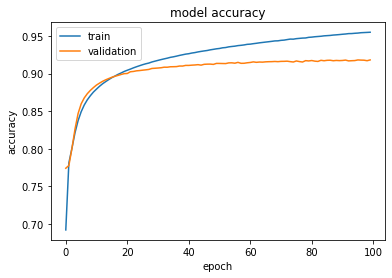

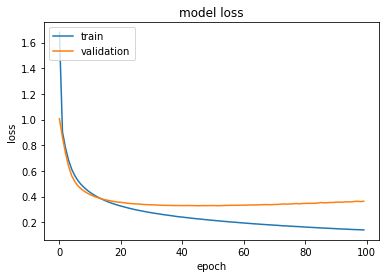

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [114]:
# Predict on the test dict
predict = model_bilstm_lstm.predict(test_input)
print(np.argmax(predict[0]))
print(index_to_tag_dict[40])
# answers = list(map(lambda x: np.argmax(x), predict))
# print(len(answers))
# print(answers)

4460
O


In [119]:
# Predict on the test dict
predict = model_bilstm_lstm.predict(test_input)
for i in range(2950):
    sentence_tag = []
    for j in range(128):
        tag = index_to_tag_dict[np.argmax(predict[i][j])]
        sentence_tag.append(tag)
    print(sentence_tag)

['O', 'O', 'IMMUNE_RESPONSE', 'IMMUNE_RESPONSE', 'O', 'ORGANISM', 'O', 'O', 'O', 'CHEMICAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'CHEMICAL', 'O', 'O', 'LIVESTOCK', 'O', 'CELL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORGANISM', 'O', 'ORGANISM', 'O', 'O', 'O', 'GENE_OR_GENOME', 'GENE_OR_GENOME', 'O', 'O', 'O', 'O', 'O', 'CHEMICAL', 'O', 'DISEASE_OR_SYNDROME', 'O', 'O', 'O', 'O', 'CHEMICAL', 'O', 'CHEMICAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'IMMUNE_RESPONSE', 'IMMUNE_RESPONSE', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'CHEMICAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'CHEMICAL', 'O', 'O', 'O', 'O', 'CELL_FUNCTION', 'O', 'O', 'O', 'O', 'O', 'CELL_COMPONENT', 'O', 'O']
['O', 'O', 'O', 'GENE_OR_GENOME', 'O', 'GENE_OR_GENOME', '_t_pad_', '_t_pad_', '_t_pad_', '_t_pad_', '_t_pad_', '_t_pad_', '_t_pad_', '_t_pad_', '_t_pa

In [121]:
# Save the validation accuracy for us to find the best model trained
np.save('./lstm_results/test', history.history['val_accuracy'])


In [123]:
print(np.load('./lstm_results/test.npy'))

[0.77421343 0.77784956 0.80049789 0.82631618 0.84687233 0.85972458
 0.8676033  0.8732574  0.8776589  0.88140094 0.88476962 0.88734108
 0.88972723 0.89173198 0.89343482 0.89506888 0.89643538 0.89755297
 0.89878708 0.89985436 0.90009004 0.9023729  0.90280193 0.90360963
 0.90397775 0.90448093 0.90493113 0.90546608 0.90676641 0.90703124
 0.90735167 0.90772247 0.9084534  0.9084031  0.90900421 0.90909165
 0.90922672 0.90998411 0.90996295 0.91083157 0.91080773 0.91115731
 0.91140097 0.91181672 0.91116792 0.91226959 0.91248673 0.91254503
 0.91216898 0.91347724 0.91343749 0.91334218 0.91325474 0.91415519
 0.9142558  0.91376323 0.91485167 0.91359907 0.91367054 0.91430348
 0.91471928 0.91550583 0.91491789 0.91530454 0.91515362 0.91556144
 0.91574419 0.91581565 0.916062   0.91580772 0.91617322 0.91623414
 0.91644597 0.91583949 0.9153443  0.91673464 0.9159084  0.91532576
 0.91714245 0.91675586 0.91729081 0.91648573 0.91610962 0.91760063
 0.91701007 0.91757149 0.91769069 0.91702068 0.91742849 0.9171